In [1]:
# 导入相关库

# PyTorch 库
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 工具库
import numpy as np
import cv2
import random
import time
import os
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from torch.autograd import Variable
import numpy as np
from math import exp
from PIL import Image

In [2]:
# SSIM损失函数实现

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [3]:
'''
Dataset for Training.
'''
class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        '''
        Ensure input and label are in couple.
        '''
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)

        
        return input, label

'''
Dataset for testing.
'''
class MyValidDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        
        return input, label

In [4]:
# 网络架构

class PReNet_r(nn.Module):
    def __init__(self, recurrent_iter=6, use_GPU=True):
        super(PReNet_r, self).__init__()
        self.iteration = recurrent_iter
        self.use_GPU = use_GPU

        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.res_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU()
            )
        self.conv_i = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_f = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv_g = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Tanh()
            )
        self.conv_o = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, 1, 1),
            nn.Sigmoid()
            )
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
            )


    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        #mask = Variable(torch.ones(batch_size, 3, row, col)).cuda()
        x = input
        h = Variable(torch.zeros(batch_size, 32, row, col))
        c = Variable(torch.zeros(batch_size, 32, row, col))

        if self.use_GPU:
            h = h.cuda()
            c = c.cuda()

        x_list = []
        for i in range(self.iteration):
            x = torch.cat((input, x), 1)
            x = self.conv0(x)

            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * torch.tanh(c)

            x = h
            for j in range(5):
                resx = x
                x = F.relu(self.res_conv1(x) + resx)

            x = self.conv(x)
            x = input + x
            x_list.append(x)

        return x, x_list

In [5]:
'''
Check the number of GPU.
'''
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


Restart...


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 001/100 ] SSIM_loss = -50.85866


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 001/100 ] SSIM_loss = -6.38245
[ Valid | 001/100 ] SSIM_loss = -6.38245 -> best
Best model found at epoch 1, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 002/100 ] SSIM_loss = -52.51523


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 002/100 ] SSIM_loss = -6.46239
[ Valid | 002/100 ] SSIM_loss = -6.46239 -> best
Best model found at epoch 2, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 003/100 ] SSIM_loss = -53.02367


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 003/100 ] SSIM_loss = -6.49944
[ Valid | 003/100 ] SSIM_loss = -6.49944 -> best
Best model found at epoch 3, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 004/100 ] SSIM_loss = -53.39978


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 004/100 ] SSIM_loss = -6.53562
[ Valid | 004/100 ] SSIM_loss = -6.53562 -> best
Best model found at epoch 4, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 005/100 ] SSIM_loss = -53.70162


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 005/100 ] SSIM_loss = -6.56876
[ Valid | 005/100 ] SSIM_loss = -6.56876 -> best
Best model found at epoch 5, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 006/100 ] SSIM_loss = -53.70854


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 006/100 ] SSIM_loss = -6.56753
[ Valid | 006/100 ] SSIM_loss = -6.56753


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 007/100 ] SSIM_loss = -53.79601


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 007/100 ] SSIM_loss = -6.53916
[ Valid | 007/100 ] SSIM_loss = -6.53916


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 008/100 ] SSIM_loss = -53.92349


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 008/100 ] SSIM_loss = -6.60141
[ Valid | 008/100 ] SSIM_loss = -6.60141 -> best
Best model found at epoch 8, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 009/100 ] SSIM_loss = -54.05000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 009/100 ] SSIM_loss = -6.53999
[ Valid | 009/100 ] SSIM_loss = -6.53999


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 010/100 ] SSIM_loss = -53.88862


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 010/100 ] SSIM_loss = -6.56831
[ Valid | 010/100 ] SSIM_loss = -6.56831


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 011/100 ] SSIM_loss = -54.23565


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 011/100 ] SSIM_loss = -6.64320
[ Valid | 011/100 ] SSIM_loss = -6.64320 -> best
Best model found at epoch 11, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 012/100 ] SSIM_loss = -54.28601


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 012/100 ] SSIM_loss = -6.62580
[ Valid | 012/100 ] SSIM_loss = -6.62580


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 013/100 ] SSIM_loss = -54.35569


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 013/100 ] SSIM_loss = -6.63117
[ Valid | 013/100 ] SSIM_loss = -6.63117


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 014/100 ] SSIM_loss = -54.41180


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 014/100 ] SSIM_loss = -6.64047
[ Valid | 014/100 ] SSIM_loss = -6.64047


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 015/100 ] SSIM_loss = -54.47028


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 015/100 ] SSIM_loss = -6.64636
[ Valid | 015/100 ] SSIM_loss = -6.64636 -> best
Best model found at epoch 15, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 016/100 ] SSIM_loss = -54.47483


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 016/100 ] SSIM_loss = -6.65317
[ Valid | 016/100 ] SSIM_loss = -6.65317 -> best
Best model found at epoch 16, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 017/100 ] SSIM_loss = -54.54515


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 017/100 ] SSIM_loss = -6.66109
[ Valid | 017/100 ] SSIM_loss = -6.66109 -> best
Best model found at epoch 17, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 018/100 ] SSIM_loss = -54.56443


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 018/100 ] SSIM_loss = -6.62954
[ Valid | 018/100 ] SSIM_loss = -6.62954


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 019/100 ] SSIM_loss = -54.56913


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 019/100 ] SSIM_loss = -6.67491
[ Valid | 019/100 ] SSIM_loss = -6.67491 -> best
Best model found at epoch 19, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 020/100 ] SSIM_loss = -54.67400


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 020/100 ] SSIM_loss = -6.66830
[ Valid | 020/100 ] SSIM_loss = -6.66830


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 021/100 ] SSIM_loss = -54.73287


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 021/100 ] SSIM_loss = -6.68701
[ Valid | 021/100 ] SSIM_loss = -6.68701 -> best
Best model found at epoch 21, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 022/100 ] SSIM_loss = -54.69961


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 022/100 ] SSIM_loss = -6.66493
[ Valid | 022/100 ] SSIM_loss = -6.66493


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 023/100 ] SSIM_loss = -54.78389


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 023/100 ] SSIM_loss = -6.68025
[ Valid | 023/100 ] SSIM_loss = -6.68025


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 024/100 ] SSIM_loss = -54.84352


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 024/100 ] SSIM_loss = -6.68590
[ Valid | 024/100 ] SSIM_loss = -6.68590


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 025/100 ] SSIM_loss = -54.85962


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 025/100 ] SSIM_loss = -6.69639
[ Valid | 025/100 ] SSIM_loss = -6.69639 -> best
Best model found at epoch 25, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 026/100 ] SSIM_loss = -54.87015


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 026/100 ] SSIM_loss = -6.68929
[ Valid | 026/100 ] SSIM_loss = -6.68929


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 027/100 ] SSIM_loss = -54.78821


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 027/100 ] SSIM_loss = -6.67795
[ Valid | 027/100 ] SSIM_loss = -6.67795


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 028/100 ] SSIM_loss = -54.91155


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 028/100 ] SSIM_loss = -6.70155
[ Valid | 028/100 ] SSIM_loss = -6.70155 -> best
Best model found at epoch 28, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 029/100 ] SSIM_loss = -54.96298


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 029/100 ] SSIM_loss = -6.62959
[ Valid | 029/100 ] SSIM_loss = -6.62959


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 030/100 ] SSIM_loss = -54.93864


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 030/100 ] SSIM_loss = -6.71297
[ Valid | 030/100 ] SSIM_loss = -6.71297 -> best
Best model found at epoch 30, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 031/100 ] SSIM_loss = -54.98247


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 031/100 ] SSIM_loss = -6.69945
[ Valid | 031/100 ] SSIM_loss = -6.69945


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 032/100 ] SSIM_loss = -55.03673


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 032/100 ] SSIM_loss = -6.68355
[ Valid | 032/100 ] SSIM_loss = -6.68355


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 033/100 ] SSIM_loss = -55.04486


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 033/100 ] SSIM_loss = -6.71778
[ Valid | 033/100 ] SSIM_loss = -6.71778 -> best
Best model found at epoch 33, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 034/100 ] SSIM_loss = -55.10001


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 034/100 ] SSIM_loss = -6.69186
[ Valid | 034/100 ] SSIM_loss = -6.69186


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 035/100 ] SSIM_loss = -55.08165


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 035/100 ] SSIM_loss = -6.68364
[ Valid | 035/100 ] SSIM_loss = -6.68364


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 036/100 ] SSIM_loss = -55.06483


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 036/100 ] SSIM_loss = -6.68938
[ Valid | 036/100 ] SSIM_loss = -6.68938


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 037/100 ] SSIM_loss = -55.13601


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 037/100 ] SSIM_loss = -6.71498
[ Valid | 037/100 ] SSIM_loss = -6.71498


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 038/100 ] SSIM_loss = -55.05225


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 038/100 ] SSIM_loss = -6.68897
[ Valid | 038/100 ] SSIM_loss = -6.68897


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 039/100 ] SSIM_loss = -55.15742


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 039/100 ] SSIM_loss = -6.67333
[ Valid | 039/100 ] SSIM_loss = -6.67333


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 040/100 ] SSIM_loss = -55.17686


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 040/100 ] SSIM_loss = -6.68407
[ Valid | 040/100 ] SSIM_loss = -6.68407


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 041/100 ] SSIM_loss = -55.15528


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 041/100 ] SSIM_loss = -6.67382
[ Valid | 041/100 ] SSIM_loss = -6.67382


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 042/100 ] SSIM_loss = -55.19427


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 042/100 ] SSIM_loss = -6.71428
[ Valid | 042/100 ] SSIM_loss = -6.71428


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 043/100 ] SSIM_loss = -55.23071


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 043/100 ] SSIM_loss = -6.71963
[ Valid | 043/100 ] SSIM_loss = -6.71963 -> best
Best model found at epoch 43, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 044/100 ] SSIM_loss = -55.26213


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 044/100 ] SSIM_loss = -6.71146
[ Valid | 044/100 ] SSIM_loss = -6.71146


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 045/100 ] SSIM_loss = -55.20141


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 045/100 ] SSIM_loss = -6.72038
[ Valid | 045/100 ] SSIM_loss = -6.72038 -> best
Best model found at epoch 45, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 046/100 ] SSIM_loss = -55.20349


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 046/100 ] SSIM_loss = -6.70981
[ Valid | 046/100 ] SSIM_loss = -6.70981


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 047/100 ] SSIM_loss = -55.20509


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 047/100 ] SSIM_loss = -6.71072
[ Valid | 047/100 ] SSIM_loss = -6.71072


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 048/100 ] SSIM_loss = -55.10087


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 048/100 ] SSIM_loss = -6.69294
[ Valid | 048/100 ] SSIM_loss = -6.69294


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 049/100 ] SSIM_loss = -55.22341


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 049/100 ] SSIM_loss = -6.70876
[ Valid | 049/100 ] SSIM_loss = -6.70876


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 050/100 ] SSIM_loss = -55.27138


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 050/100 ] SSIM_loss = -6.72364
[ Valid | 050/100 ] SSIM_loss = -6.72364 -> best
Best model found at epoch 50, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 051/100 ] SSIM_loss = -55.23298


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 051/100 ] SSIM_loss = -6.71730
[ Valid | 051/100 ] SSIM_loss = -6.71730


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 052/100 ] SSIM_loss = -55.30533


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 052/100 ] SSIM_loss = -6.70516
[ Valid | 052/100 ] SSIM_loss = -6.70516


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 053/100 ] SSIM_loss = -55.32398


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 053/100 ] SSIM_loss = -6.71643
[ Valid | 053/100 ] SSIM_loss = -6.71643


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 054/100 ] SSIM_loss = -55.34621


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 054/100 ] SSIM_loss = -6.68974
[ Valid | 054/100 ] SSIM_loss = -6.68974


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 055/100 ] SSIM_loss = -55.35150


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 055/100 ] SSIM_loss = -6.69862
[ Valid | 055/100 ] SSIM_loss = -6.69862


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 056/100 ] SSIM_loss = -55.35749


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 056/100 ] SSIM_loss = -6.73633
[ Valid | 056/100 ] SSIM_loss = -6.73633 -> best
Best model found at epoch 56, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 057/100 ] SSIM_loss = -55.31647


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 057/100 ] SSIM_loss = -6.71233
[ Valid | 057/100 ] SSIM_loss = -6.71233


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 058/100 ] SSIM_loss = -55.38247


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 058/100 ] SSIM_loss = -6.72154
[ Valid | 058/100 ] SSIM_loss = -6.72154


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 059/100 ] SSIM_loss = -55.36184


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 059/100 ] SSIM_loss = -6.70317
[ Valid | 059/100 ] SSIM_loss = -6.70317


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 060/100 ] SSIM_loss = -55.21355


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 060/100 ] SSIM_loss = -6.66288
[ Valid | 060/100 ] SSIM_loss = -6.66288


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 061/100 ] SSIM_loss = -55.24913


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 061/100 ] SSIM_loss = -6.69567
[ Valid | 061/100 ] SSIM_loss = -6.69567


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 062/100 ] SSIM_loss = -55.39472


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 062/100 ] SSIM_loss = -6.72042
[ Valid | 062/100 ] SSIM_loss = -6.72042


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 063/100 ] SSIM_loss = -55.41532


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 063/100 ] SSIM_loss = -6.70543
[ Valid | 063/100 ] SSIM_loss = -6.70543


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 064/100 ] SSIM_loss = -55.36789


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 064/100 ] SSIM_loss = -6.73137
[ Valid | 064/100 ] SSIM_loss = -6.73137


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 065/100 ] SSIM_loss = -55.45377


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 065/100 ] SSIM_loss = -6.72633
[ Valid | 065/100 ] SSIM_loss = -6.72633


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 066/100 ] SSIM_loss = -55.43986


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 066/100 ] SSIM_loss = -6.68156
[ Valid | 066/100 ] SSIM_loss = -6.68156


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 067/100 ] SSIM_loss = -55.46160


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 067/100 ] SSIM_loss = -6.71475
[ Valid | 067/100 ] SSIM_loss = -6.71475


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 068/100 ] SSIM_loss = -55.30929


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 068/100 ] SSIM_loss = -6.73475
[ Valid | 068/100 ] SSIM_loss = -6.73475


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 069/100 ] SSIM_loss = -55.43107


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 069/100 ] SSIM_loss = -6.70689
[ Valid | 069/100 ] SSIM_loss = -6.70689


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 070/100 ] SSIM_loss = -55.47800


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 070/100 ] SSIM_loss = -6.72956
[ Valid | 070/100 ] SSIM_loss = -6.72956


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 071/100 ] SSIM_loss = -55.48339


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 071/100 ] SSIM_loss = -6.68919
[ Valid | 071/100 ] SSIM_loss = -6.68919


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 072/100 ] SSIM_loss = -55.49005


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 072/100 ] SSIM_loss = -6.68851
[ Valid | 072/100 ] SSIM_loss = -6.68851


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 073/100 ] SSIM_loss = -55.40912


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 073/100 ] SSIM_loss = -6.71971
[ Valid | 073/100 ] SSIM_loss = -6.71971


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 074/100 ] SSIM_loss = -55.41261


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 074/100 ] SSIM_loss = -6.71942
[ Valid | 074/100 ] SSIM_loss = -6.71942


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 075/100 ] SSIM_loss = -55.37001


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 075/100 ] SSIM_loss = -6.74078
[ Valid | 075/100 ] SSIM_loss = -6.74078 -> best
Best model found at epoch 75, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 076/100 ] SSIM_loss = -55.51456


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 076/100 ] SSIM_loss = -6.71261
[ Valid | 076/100 ] SSIM_loss = -6.71261


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 077/100 ] SSIM_loss = -55.53693


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 077/100 ] SSIM_loss = -6.73255
[ Valid | 077/100 ] SSIM_loss = -6.73255


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 078/100 ] SSIM_loss = -55.53249


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 078/100 ] SSIM_loss = -6.70570
[ Valid | 078/100 ] SSIM_loss = -6.70570


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 079/100 ] SSIM_loss = -55.48437


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 079/100 ] SSIM_loss = -6.73182
[ Valid | 079/100 ] SSIM_loss = -6.73182


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 080/100 ] SSIM_loss = -55.34842


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 080/100 ] SSIM_loss = -6.71406
[ Valid | 080/100 ] SSIM_loss = -6.71406


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 081/100 ] SSIM_loss = -55.53115


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 081/100 ] SSIM_loss = -6.71874
[ Valid | 081/100 ] SSIM_loss = -6.71874


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 082/100 ] SSIM_loss = -55.56787


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 082/100 ] SSIM_loss = -6.71822
[ Valid | 082/100 ] SSIM_loss = -6.71822


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 083/100 ] SSIM_loss = -55.47123


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 083/100 ] SSIM_loss = -6.72196
[ Valid | 083/100 ] SSIM_loss = -6.72196


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 084/100 ] SSIM_loss = -55.56995


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 084/100 ] SSIM_loss = -6.71879
[ Valid | 084/100 ] SSIM_loss = -6.71879


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 085/100 ] SSIM_loss = -55.55367


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 085/100 ] SSIM_loss = -6.73918
[ Valid | 085/100 ] SSIM_loss = -6.73918


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 086/100 ] SSIM_loss = -55.45678


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 086/100 ] SSIM_loss = -6.73318
[ Valid | 086/100 ] SSIM_loss = -6.73318


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 087/100 ] SSIM_loss = -55.59449


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 087/100 ] SSIM_loss = -6.73476
[ Valid | 087/100 ] SSIM_loss = -6.73476


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 088/100 ] SSIM_loss = -55.59826


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 088/100 ] SSIM_loss = -6.74255
[ Valid | 088/100 ] SSIM_loss = -6.74255 -> best
Best model found at epoch 88, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 089/100 ] SSIM_loss = -55.43618


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 089/100 ] SSIM_loss = -6.73526
[ Valid | 089/100 ] SSIM_loss = -6.73526


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 090/100 ] SSIM_loss = -55.56714


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 090/100 ] SSIM_loss = -6.72751
[ Valid | 090/100 ] SSIM_loss = -6.72751


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 091/100 ] SSIM_loss = -55.47941


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 091/100 ] SSIM_loss = -6.70286
[ Valid | 091/100 ] SSIM_loss = -6.70286


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 092/100 ] SSIM_loss = -55.60557


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 092/100 ] SSIM_loss = -6.72283
[ Valid | 092/100 ] SSIM_loss = -6.72283


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 093/100 ] SSIM_loss = -55.60015


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 093/100 ] SSIM_loss = -6.74305
[ Valid | 093/100 ] SSIM_loss = -6.74305 -> best
Best model found at epoch 93, saving model


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 094/100 ] SSIM_loss = -55.63497


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 094/100 ] SSIM_loss = -6.72511
[ Valid | 094/100 ] SSIM_loss = -6.72511


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 095/100 ] SSIM_loss = -55.63801


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 095/100 ] SSIM_loss = -6.66347
[ Valid | 095/100 ] SSIM_loss = -6.66347


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 096/100 ] SSIM_loss = -55.63931


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 096/100 ] SSIM_loss = -6.73884
[ Valid | 096/100 ] SSIM_loss = -6.73884


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 097/100 ] SSIM_loss = -55.62779


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 097/100 ] SSIM_loss = -6.73747
[ Valid | 097/100 ] SSIM_loss = -6.73747


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 098/100 ] SSIM_loss = -55.63044


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 098/100 ] SSIM_loss = -6.74192
[ Valid | 098/100 ] SSIM_loss = -6.74192


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 099/100 ] SSIM_loss = -55.66727


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 099/100 ] SSIM_loss = -6.72735
[ Valid | 099/100 ] SSIM_loss = -6.72735


  0%|          | 0/57 [00:00<?, ?it/s]

[ Train | 100/100 ] SSIM_loss = -55.63713


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 100/100 ] SSIM_loss = -6.74041
[ Valid | 100/100 ] SSIM_loss = -6.74041


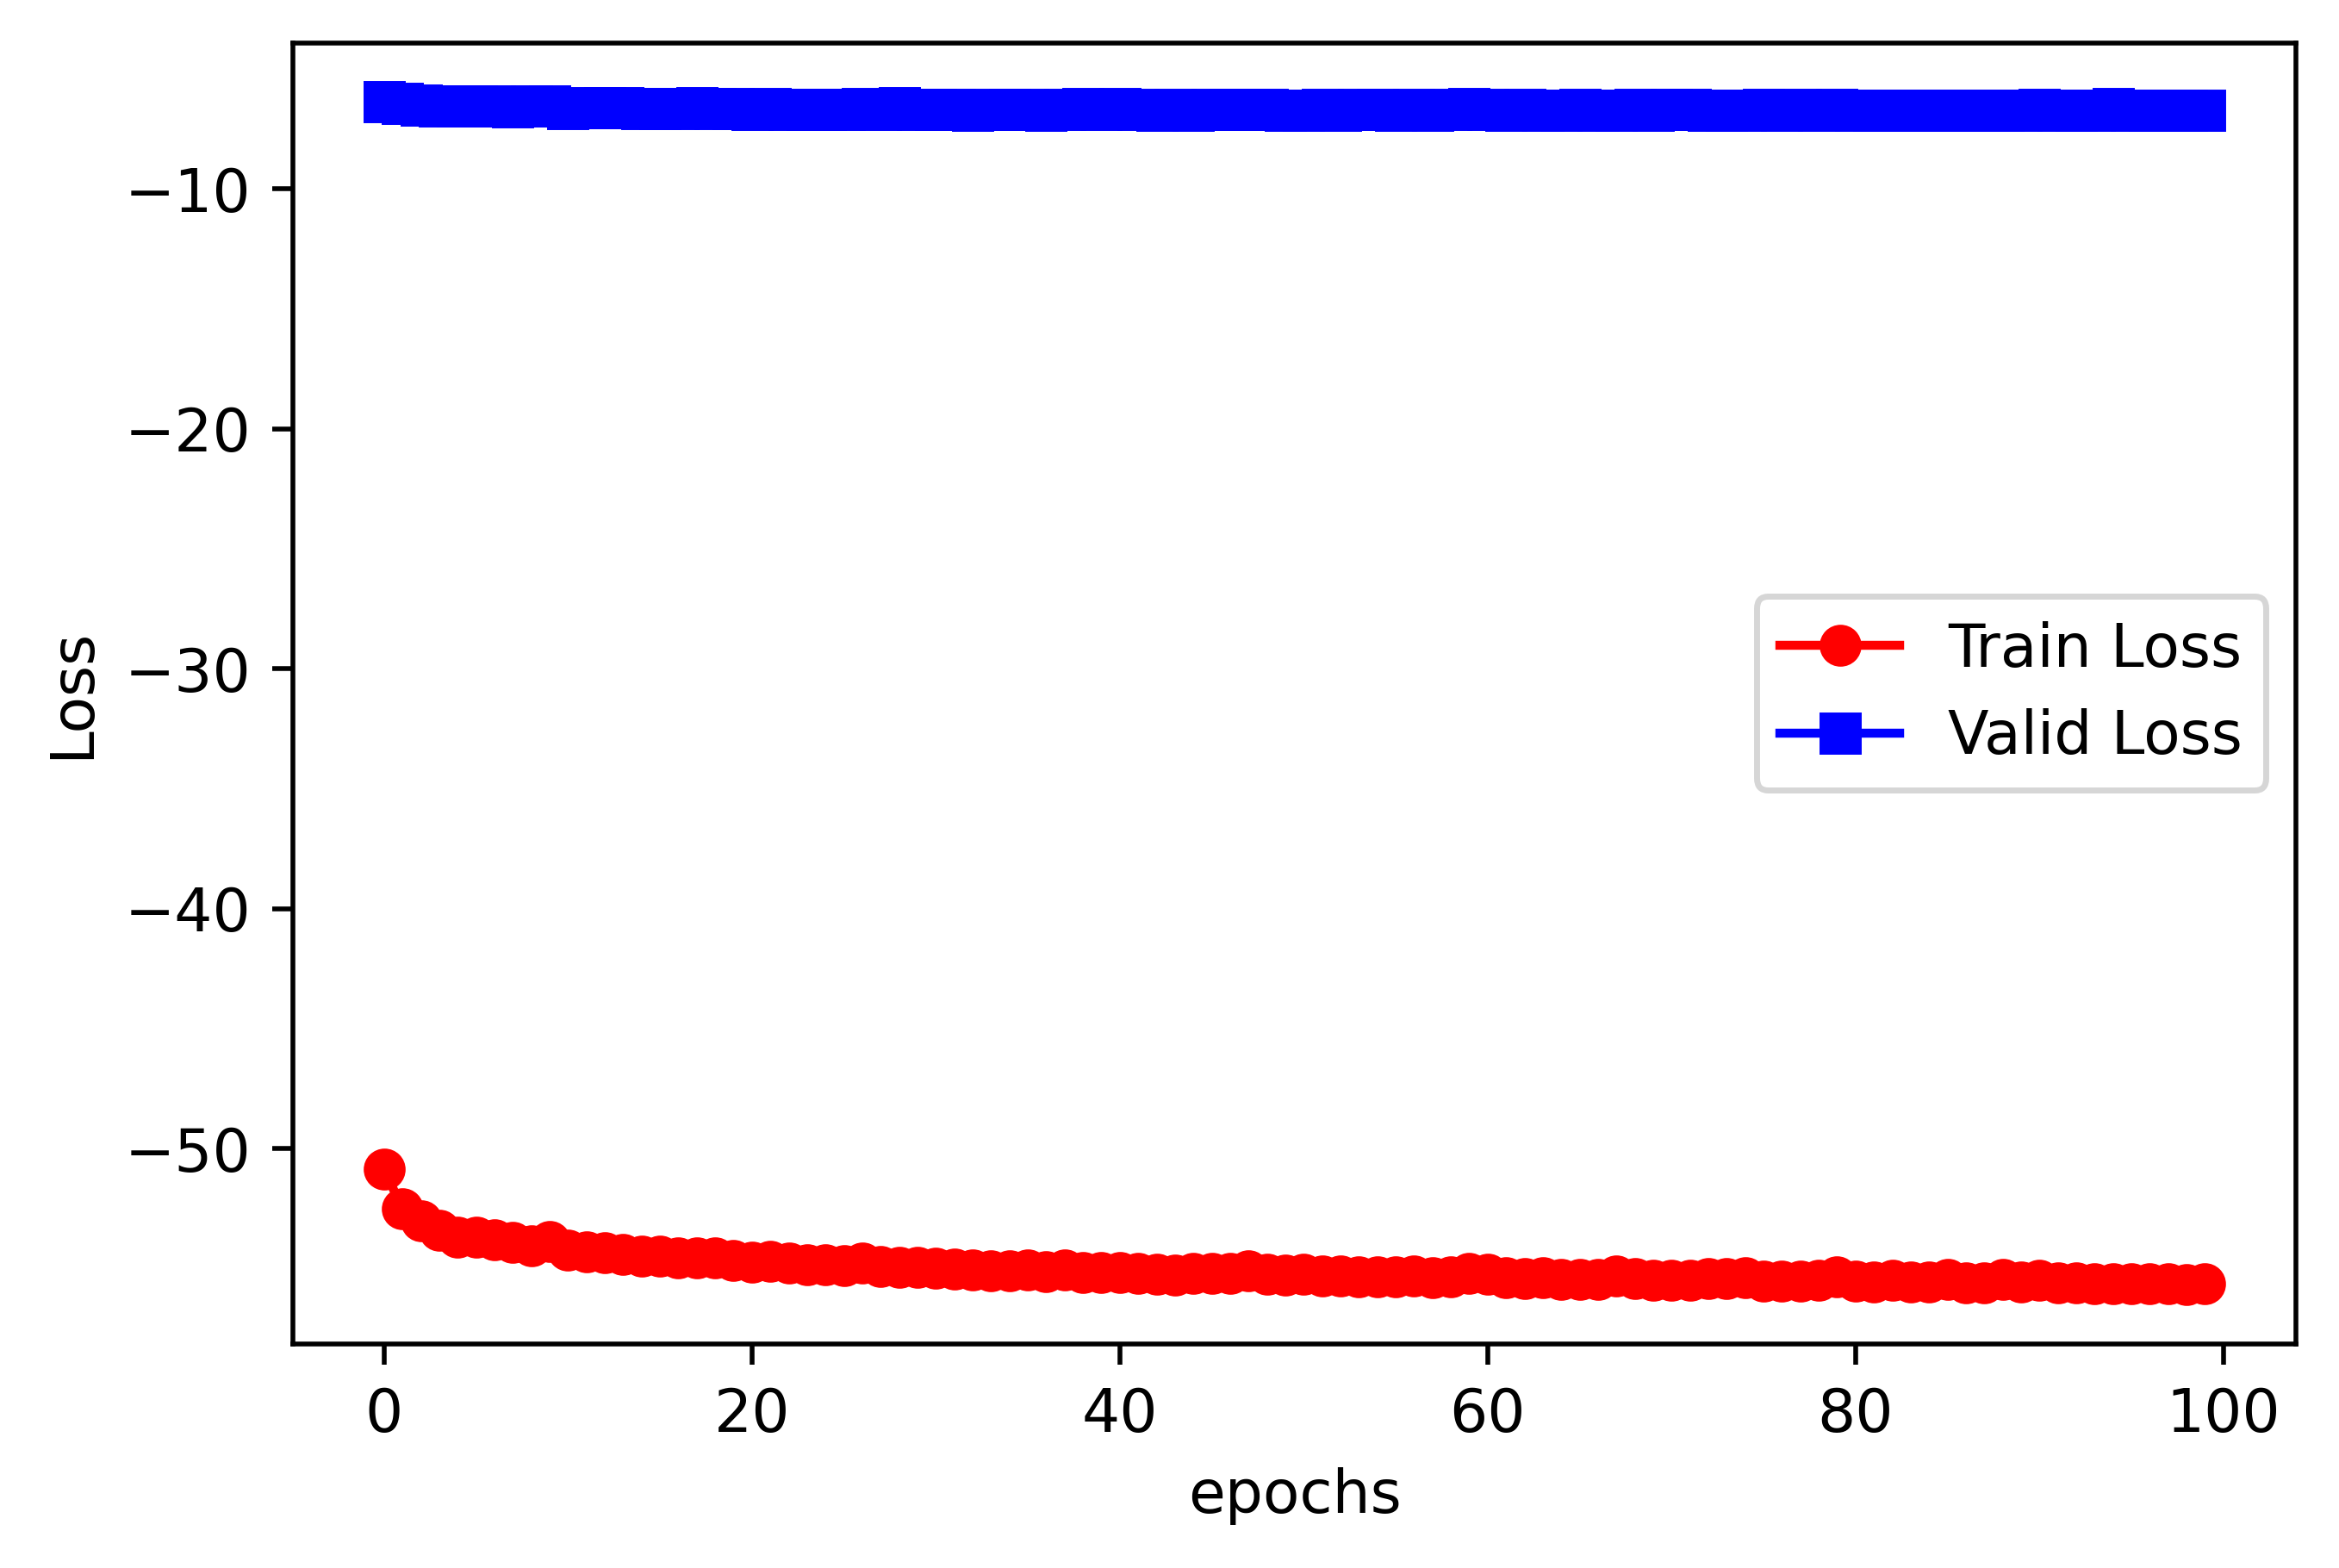

In [6]:
'''
Path of Dataset.
'''
input_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/rain"
label_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/norain"
valid_input_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/rain/X2'
valid_label_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/norain'

'''
Check the device.
'''
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

'''
Move the Network to the CUDA.
'''
net = PReNet_r().to(device)

'''
Hyper Parameters.
    TODO: fine-tuning.
'''
learning_rate = 1e-3
batch_size = 32
epoch = 100
patience = 200
stale = 0
best_valid_loss = 10000
break_point = 0

'''
Prepare for plt.
'''
Loss_list = []
Valid_Loss_list = []

'''
Define optimizer and Loss Function.
'''
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_f = SSIM()

'''
Check the model.
'''
if os.path.exists('./model.pth'): 
    print('Continue train with last model...')
    net.load_state_dict(torch.load('./model.pth'))
else: 
    print("Restart...")

'''
Prepare DataLoaders.

Attension:
    'pin_numbers=True' can accelorate CUDA computing.
'''
dataset_train = MyTrainDataset(input_path, label_path)
dataset_valid = MyValidDataset(valid_input_path, valid_label_path)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)

'''
START Training ...
'''
for i in range(epoch):
# ---------------Train----------------
    net.train()
    train_losses = []
    
    '''
    tqdm is a toolkit for progress bar.
    '''
    for batch in tqdm(train_loader):
        inputs, labels = batch
        
        outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        optimizer.zero_grad()
        
        loss.backward()
        
        '''
        Avoid grad to be too BIG.
        '''
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        
        optimizer.step()
        
        '''
        Attension:
            We need set 'loss.item()' to turn Tensor into Numpy, or plt will not work.
        '''
        train_losses.append(loss.item())
        
    train_loss = sum(train_losses)
    Loss_list.append(train_loss)
    print(f"[ Train | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {train_loss:.5f}")
    
# -------------Validation-------------
    '''
    Validation is a step to ensure training process is working.
    You can also exploit Validation to see if your net work is overfitting.
    
    Firstly, you should set model.eval(), to ensure parameters not training.
    '''
    net.eval()
    valid_losses = []
    for batch in tqdm(valid_loader):
        inputs, labels = batch
        
        '''
        Cancel gradient decent.
        '''
        with torch.no_grad():
            outputs, _ = net(inputs.to(device))
        loss = loss_f(labels.to(device), outputs)
        loss = -loss
        
        
        valid_losses.append(loss.item())
    
    valid_loss = sum(valid_losses)
    Valid_Loss_list.append(valid_loss)
    print(f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    break_point = i + 1
    
    '''
    Update Logs and save the best model.
    Patience is also checked.
        
    '''
    if valid_loss < best_valid_loss:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f} -> best")
    else:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] SSIM_loss = {valid_loss:.5f}")
    
    if valid_loss < best_valid_loss:
        print(f'Best model found at epoch {i+1}, saving model')
        torch.save(net.state_dict(), f'model_best.ckpt')
        best_valid_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvement {patience} consecutive epochs, early stopping.')
            break

'''
Use plt to draw Loss curves.
'''
plt.figure(dpi=500)
x = range(break_point)
y = Loss_list
plt.plot(x, y, 'ro-', label='Train Loss')
plt.plot(range(break_point), Valid_Loss_list, 'bs-', label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()